# **Assessing the Impact of Central Bank Speeches on Stock Prices Using LSTM and Sentiment Analysis**

## **Introduction**

This project investigates the influence of **Central Bank speeches** (available on the [BIS website](https://www.bis.org/cbspeeches)) on stock prices prediction by leveraging machine learning techniques. Specifically, we use a **Long Short-Term Memory (LSTM)** model, which is well-suited for capturing long-term trends in stock prices, as its core predictive engine. Additionally, sentiment analysis is incorporated to quantify the psychological impact of these speeches on financial markets.

To ensure a comprehensive analysis, the predictions were conducted on the **most heavily weighted companies within each sector of the S&P 500 index**. From our point of views, this approach provides insights into sector-specific influences and highlights the broader market implications of Central Bank speeches.

---

## **Motivation**

Central Banks play a pivotal role in shaping market expectations and trends through their communications. The tone and sentiment of their speeches can impact investor behavior and, consequently, stock prices. This project aims to understand and quantify this impact using an LSTM model enhanced with sentiment analysis techniques, offering a more comprehensive view than relying solely on price trends.

---

## **Objectives**

1. Evaluate the degree to which **Central Bank speeches** influence stock prices prediction.

2. Compare the performance of models that whether incorporate or not sentiment data analysis, using the **R² (Coefficient of Determination)** as the primary evaluation metric.
---

## **Methodology**

### **1. Project Structure**
In this project, we chosed to train test the relevance of sentimental analysis on Central Bank texts with three different approaches:
1. **Without Sentiment Analysis**: A baseline model relying solely on stock price data.
2. **FinBERT**: Sentiment analysis using a pre-trained transformer model tailored for financial text.
3. **Loughran-McDonald Dictionary (skfin)**: A rule-based sentiment analysis method for financial content.


For each model, we trained them following this pipeline that will be details later:
- **Data Preprocessing**: This part includes loading the data, performing or not sentiment analysis on each text from the `news` dataset. Then, we split the data into a validation set and a training set based on dates. We keep 80% of the data for training and 20% for validation. The third step consists in performing data augmentation by "sequencing" the data. Finally, we fit a `MinMaxScaler` on each sequence of the training data to ease training.
- **Model Training**: Training LSTM models with the same architectures on the corresponding feature set.
- **Model Evaluation**: Evaluating the model’s performance against its objectives, based on plots and on the value of the R².

Sentiment analysis, when used, is integrated into the preprocessing pipeline for its respective axis.

### **2. Data Collection**
To achieve this project, we needed two kinds of data : **stock prices** and **central bank speeches**. Moreover, since we chose to use a LSTM based architecture for our model, we needed a lot of data. We scraped the data the following way:

1. We retrieve historical **stock prices** using the ``yfinance`` API, which allows to freely fetch the data we needed.

2. The central bank **Speeches** were extracted from the [BIS Central Bank speeches database](https://www.bis.org/cbspeeches), to perform this, we built a Python script using the python modules `Playwright` to get the url of each articles and `Beautiful Soup` to recover the texts. We manually choose some parameters in order to get text with release dates that fit the dates of the stock prices.

Since the notebook had to be reproductible and in order to have a reasonible time for training, we decided to focus on key companies of the S&P500

### **3. Sentiment Analysis**
Sentiment analysis is performed within the respective preprocessing pipelines for FinBERT and skfin-based approaches:
- **FinBERT**: Extracted sentiment scores (`positive`, `negative`, `neutral`) for each speech, processed with a transformer model fine-tuned for financial sentiment.
- **Loughran-McDonald Dictionary (skfin)**: Applied rule-based sentiment scoring using a dictionary of sentiment-related terms, aggregating results to align with stock price movements.
Sentiment scores, when used, are integrated into the feature set to train the LSTM model.

### **4. LSTM Based Model Implementation**
An **LSTM model class** was implemented for our needs, it's not that much far from an LSTM, the precise architecture will be detailed bellow. We used as much techniques as we knew so far to ease training, this includes Batch training, use of a scheduler and early stopping. We relied on Adam optimizer to get the best training as possible. 

# Additional module setup

In [ ]:
%pip install -U pyee playwright

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from torch.optim.lr_scheduler import OneCycleLR
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# From skfin
from sklearn.feature_extraction.text import CountVectorizer

c:\Users\mcgpr\anaconda3\envs\skfin\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Data Scraping

In [ ]:
import os
from bs4 import BeautifulSoup
import pandas as pd
import re
from playwright.async_api import async_playwright
import asyncio
import requests
from tqdm import tqdm
import nest_asyncio

nest_asyncio.apply()  # Allow nested event loops

async def get_BIS_press_urls():
    """Scrape all BIS press release URLs and their dates using Playwright's Async API."""
    articles = []

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)  # Launch the browser in headless mode
        page = await browser.new_page()  # Open a new page
        
        for k in tqdm(range(1, 717)):  # Iterate through pages
            url = f"https://www.bis.org/cbspeeches/index.htm?cbspeeches_page={k}"            
            # Navigate to the page
            await page.goto(url)
            await asyncio.sleep(0.5)  # Add a delay to ensure the page fully loads

            # Extract rendered HTML
            html = await page.content()
            soup = BeautifulSoup(html, "html.parser")

            rows = soup.find_all('tr', class_='item')
            for row in rows:
                # Extract the date
                date_cell = row.find('td', class_='item_date')
                date = date_cell.get_text(strip=True) if date_cell else "No date available"
                # Extract the URL
                link = row.find('a', href=re.compile(r"^/review/r\d{6}[a-z]?.htm$"))
                if link and link.get('href'):
                    url = f"https://www.bis.org{link['href']}"
                    title = link.get_text(strip=True)
                else:
                    url = None
                    title = "No title available"

                articles.append({
                    "date": date,
                    "url": url,
                    "title": title
                })

        await browser.close()
    return articles

def get_text_from_url(url):
    """Visit a URL and retrieve the text of all <p> tags."""
    if not url:
        print("Error: No URL provided.")  # Log error for missing URL
        return ""

    # Perform the GET request
    response = requests.get(url, timeout=500)
    if response.status_code != 200:
        print(f"Error fetching content from {url}: Status code {response.status_code}")
        return ""

    soup = BeautifulSoup(response.text, "html.parser")

    # Find all <p> tags on the page
    paragraphs = soup.find_all('p')
    if not paragraphs:
        print(f"No <p> tags found on {url}")
        return ""

    # Combine the text from all <p> tags
    text = " ".join(p.get_text(strip=True) for p in paragraphs)
    return text

def save_to_csv(data, output_file="data/bis_press_releases.csv"):
    """Save data (URLs, dates, titles, and text content) to a CSV file."""
    if not data:
        print("No data found to save.")
        return

    # Ensure the output directory exists
    output_dir = os.path.dirname(output_file)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Directory '{output_dir}' created.")

    # Create a DataFrame and save it to a CSV file
    df = pd.DataFrame(data)  # Create a DataFrame with the articles
    df.to_csv(output_file, index=False, encoding="utf-8")
    print(f"Saved {len(data)} entries to '{output_file}'.")

async def main():
    # Scrape press release URLs
    articles = await get_BIS_press_urls()
    print(f"Found {len(articles)} articles. Start scraping content...")

    # Retrieve text content from each URL
    for article in tqdm(articles):
        if article['url']:
            content = get_text_from_url(article['url'])  # Pass only the URL to the function
            article["content"] = content  # Add the retrieved content to the article dictionary
        else:
            print(f"Skipping article with missing URL: {article}")  # Debug: Missing URL

    # Save the articles with content to a CSV
    save_to_csv(articles)

# Run the async main function
if __name__ == "__main__":
    asyncio.run(main())


In [ ]:
import asyncio
import os
import pandas as pd
import yfinance as yf
from datetime import datetime
from tqdm.asyncio import tqdm

# Function to fetch S&P 500 tickers and companies from Wikipedia
def get_sp500_tickers():
    sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(sp500_url)
    sp500_table = table[0]  # The S&P 500 list is in the first table on the page

    # Dynamically identify the column for tickers and company names
    ticker_column = [col for col in sp500_table.columns if "Ticker" in col or "Symbol" in col][0]
    company_column = [col for col in sp500_table.columns if "Security" in col or "Company" in col][0]

    tickers = sp500_table[ticker_column].tolist()
    companies = sp500_table[company_column].tolist()

    print('Tickers and Companies fetched:', len(tickers))
    return tickers, companies

# Asynchronous wrapper for yf.download
async def async_download(ticker, start_date, end_date):
    loop = asyncio.get_event_loop()
    try:
        data = await loop.run_in_executor(None, lambda: yf.download(ticker, start_date, end_date, progress=False))
        return data
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return None

# Function to fetch data with retries and clean it
async def fetch_with_retries(ticker, company, start_date, end_date, retries=3, delay=1):
    for attempt in range(retries):
        data = await async_download(ticker, start_date, end_date)

        if data is not None and not data.empty:
            # Prepare clean data
            data["Company"] = company
            data = data.reset_index()  # Ensure 'Date' is a column
            data = data[["Date", "Open", "High", "Low", "Close", "Volume", "Company"]]
            data['Date'] = pd.to_datetime(data['Date'])
            data = data.values
            columns = ["Date", "Open", "High", "Low", "Close", "Volume", "Company"]
            data = pd.DataFrame(data, columns=columns)
            return data
        await asyncio.sleep(delay)

    print(f"Failed to fetch data for {ticker} after {retries} retries.")
    return pd.DataFrame()

# Main function to fetch all data
async def fetch_all_data(start_date, end_date, delay_between_requests=0.5):
    tickers, companies = get_sp500_tickers()
    results = []
    with tqdm(total=len(tickers), desc="Fetching data", dynamic_ncols=True) as pbar:
        for ticker, company in zip(tickers, companies):
            raw_data = await fetch_with_retries(ticker, company, start_date, end_date)
            if not raw_data.empty:
                results.append(raw_data)
            await asyncio.sleep(delay_between_requests)
            pbar.update(1)
    return pd.concat(results, ignore_index=True) if results else pd.DataFrame()

# Entry point
if __name__ == "__main__":
    start_date = "2017-01-01"
    end_date = datetime.now().strftime("%Y-%m-%d")

    try:
        print("Fetching S&P 500 data...")
        all_data = asyncio.run(fetch_all_data(start_date, end_date))

        if not all_data.empty:
            print("Data successfully fetched. Converting to DataFrame...")
            all_data["Date"] = pd.to_datetime(all_data["Date"])  # Ensure 'Date' is in datetime format
            all_data = all_data.sort_values(by="Date")  # Sort by date

            # Save the cleaned data to CSV
            os.makedirs("data", exist_ok=True)
            output_file = "data/sp500_prices.csv"
            all_data.to_csv(output_file, index=False)
            print(f"All data saved to '{output_file}'")
        else:
            print("No data was fetched.")
    except KeyboardInterrupt:
        print("Process interrupted by user.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Utils

Here are some functions and classes that we'll use many times through the code to preprocess, sequence and generate the different results obtained. They all contain a short description for clarity.

## Functions

In [3]:
def load_data(include_news=False):
    """
    Loads financial price data and optionally economic news data.
    """
    prices = pd.read_csv('data/sp500_prices.csv')
    prices['date'] = pd.to_datetime(prices['Date'])
    prices = prices.drop(columns=['Date'])
    prices.sort_values(by='date', ascending=True, inplace=True)

    if include_news:
        news = pd.read_csv('data/bis_press_releases.csv')
        news = news.dropna()
        news['date'] = pd.to_datetime(news['date'], format='%d %b %Y')
        news.sort_values(by='date', ascending=True, inplace=True)
        return prices, news
    else:
        return prices

In [4]:
def sequencing(df, companies, sequence_length, include_news=False):
    """
    Prepares sequenced data for time series analysis with optional sentiment features.
    """
    data = []
    for company in companies:
        if include_news:
            if 'neutral' in df.columns:
                company_data = df[df['Company'] == company][['Close', 'negative', 'neutral', 'positive']].values
            else:
                company_data = df[df['Company'] == company][['Close', 'negative', 'positive']].values
            for i in range(company_data.shape[0]):
                sentiment_values = company_data[i, 1:]
                max_index = np.argmax(sentiment_values)
                binary_sentiment = np.zeros_like(sentiment_values)
                binary_sentiment[max_index] = 1
                company_data[i, 1:] = binary_sentiment
            data.append(company_data)
        else:
            company_data = df[df['Company'] == company][['Close']].values
            data.append(company_data)
    sequenced_data = []
    for d in data:
        if d.shape[0] <= sequence_length:
            print(d.shape)
            continue
        for k in range(d.shape[0] - sequence_length):
            sequence = d[k:k + sequence_length, :]
            sequenced_data.append(sequence)
    sequenced_data = np.array(sequenced_data)
    return sequenced_data

In [5]:
def scale_sequences(data):
    """
    For each sequence of a data input array, we fir a MinMaxScaler with feature range (0,1). The output is the whole data scaled
    and the scalers, which will be useful for the evaluation part.
    """
    scaled_data = np.copy(data)  # Copy input data to preserve original structure
    scalers = []

    for i in range(data.shape[0]):  # Iterate through sequences
        scaler = MinMaxScaler(feature_range=(0, 1))
        sequence = data[i, :, 0].reshape(-1, 1)  # Shape: (seq_len, 1)
        scaled_sequence = scaler.fit_transform(sequence)
        scaled_data[i, :, 0] = scaled_sequence.flatten()
        scalers.append(scaler)  # Store the scaler for later inverse transformation
    return scaled_data, scalers

In [6]:
def evaluate_model(model, data_loader, criterion, scalers):
    """
    Evaluates the performance of a trained model on a validation dataset.
    """
    model.eval()
    predictions = []
    targets = []
    test_loss = 0
    idx = 0  # Index to track sequence-specific scalers

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            test_loss += loss.item()
            preds = outputs.squeeze().cpu().numpy()
            true_values = y_batch.cpu().numpy()

            # Inverse transform each sequence individually using its scaler
            for i in range(len(preds)):
                preds[i] = scalers[idx].inverse_transform([[preds[i]]])[0][0]  # First feature
                true_values[i] = scalers[idx].inverse_transform([[true_values[i]]])[0][0]  # First feature
                idx += 1  # Move to the next scaler for the next sequence

            predictions.extend(preds)
            targets.extend(true_values)

    # Return flattened predictions, targets, and average loss
    return np.array(predictions), np.array(targets), test_loss / len(data_loader)

## Classes

In [7]:
class TimeSeriesDataset(Dataset):
    """
    Custom PyTorch Dataset for time series data.
    """
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx, :-1, :]
        y = self.data[idx, -1, 0]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [8]:
class LSTM(nn.Module):
    """
    Custom LSTM model for time series prediction.
    """
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, intermediate_dim=64, seed=42):
        super(LSTM, self).__init__()
        self.linear = nn.Linear(input_dim, intermediate_dim)
        self.sigmoid = nn.Sigmoid()
        self.initial_linear = nn.Linear(intermediate_dim, intermediate_dim)
        self.lstm = nn.LSTM(intermediate_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.seed = seed
        self.init_weights()
    
    def forward(self, x):
        # Pass through the initial linear layer
        x = self.linear(x)
        x = self.sigmoid(x)
        x = self.initial_linear(x)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out
    
    def init_weights(self):
        torch.manual_seed(self.seed)
        nn.init.xavier_uniform_(self.linear.weight.data)
        nn.init.constant_(self.linear.bias.data, 0)
        # Initialize weights for the initial linear layer
        nn.init.xavier_uniform_(self.initial_linear.weight.data)
        nn.init.constant_(self.initial_linear.bias.data, 0)

        # Initialize weights for the LSTM layer
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)

        # Initialize weights for the fully connected layer
        nn.init.xavier_uniform_(self.fc.weight.data)
        nn.init.constant_(self.fc.bias.data, 0)

In [9]:
class EarlyStopping:
    """
    Custom Early Stopping class.
    """
    def __init__(self, patience=10, verbose=True, min_delta=1e-4, save_path="best_model.pth"):
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.save_path = save_path

    def __call__(self, val_loss, model):
            if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
                # New best loss found, save the model
                self.best_loss = val_loss
                self.counter = 0
                torch.save(model.state_dict(), self.save_path)
                if self.verbose:
                    print(f"Validation loss improved. Model saved to {self.save_path}")
            else:
                # No improvement, increment counter
                self.counter += 1
                if self.verbose:
                    print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
                if self.counter >= self.patience:
                    self.early_stop = True
                    print("Early stopping triggered.")

# General Remarks on the code

The reader will notice that some hyperparameters haven't been tuned. This is because in the case of our study, we would like to compare one single architecture 

# Training the LSTM based model only using price data.

## Preprocessing

### Data processing

In [10]:
companies = [
    'Amazon', 'Apple Inc.', 'Meta Platforms', 'UnitedHealth Group', 
    'Procter & Gamble', 'Honeywell', 'ExxonMobil', 'NextEra Energy', 
    'American Tower', 'JPMorgan Chase'
]

In [11]:
prices = load_data()

In [12]:
def date_train_val_split(df, train_size=0.8):
    dates = df['date'].drop_duplicates().values
    split_date = dates[int(train_size * len(dates))]

    train = df[df['date'] <= split_date]
    val = df[df['date'] > split_date]
    return train, val, split_date

In [13]:
train, val, split_date = date_train_val_split(prices, train_size=0.8)

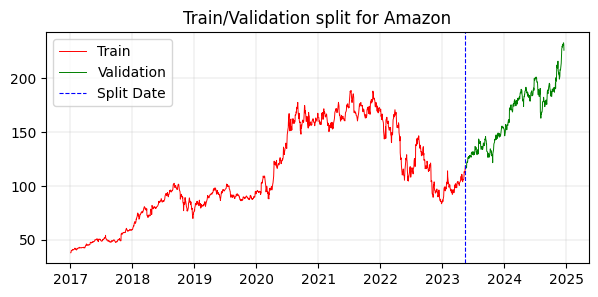

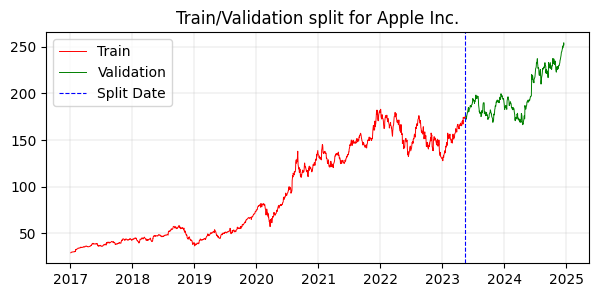

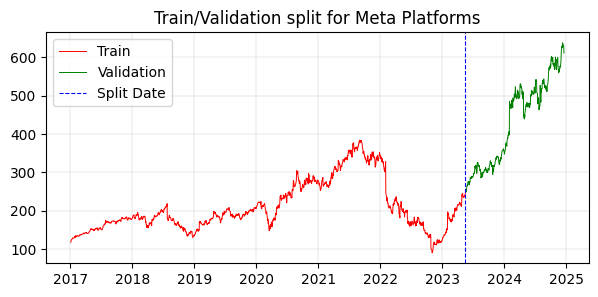

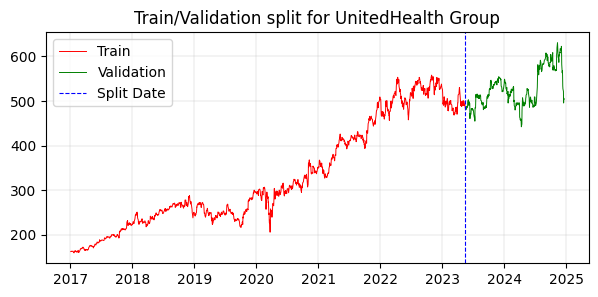

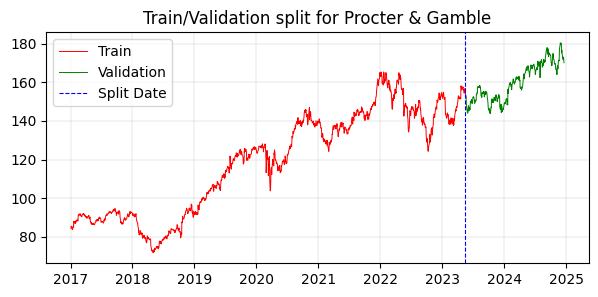

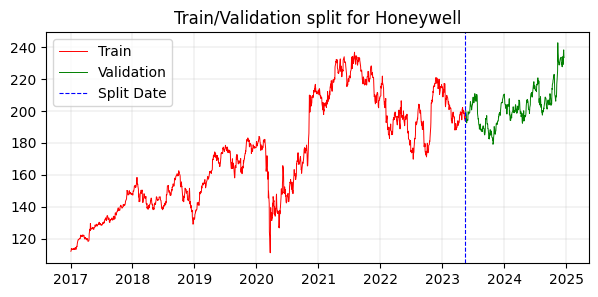

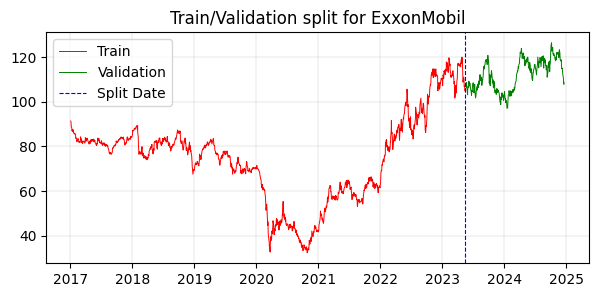

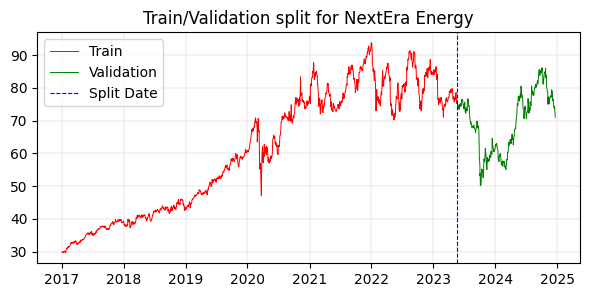

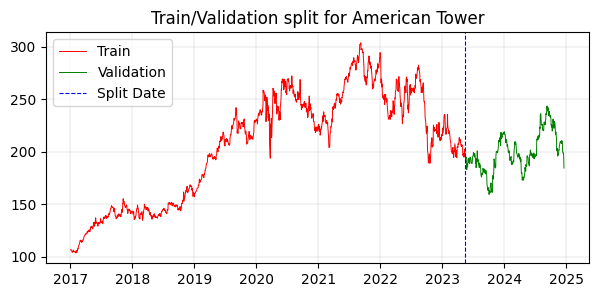

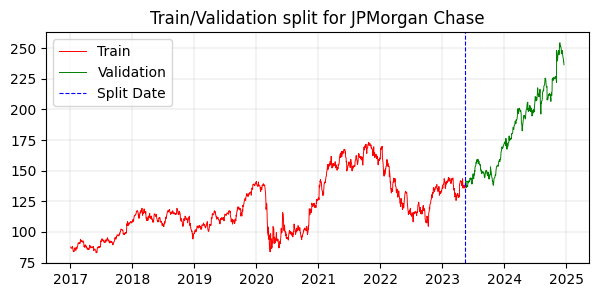

In [14]:
for company in companies:
    train_ex = train[train['Company'] == company]['High'].values
    train_dates = train['date'].drop_duplicates().values
    val_ex = val[val['Company'] == company]['High'].values
    val_dates = val['date'].drop_duplicates().values

    plt.figure(figsize=(7, 3))
    plt.grid(linewidth=0.2)
    plt.plot(train_dates, train_ex, linewidth=0.7, label='Train', c='r')
    plt.plot(val_dates, val_ex, linewidth=0.7, label='Validation', c='g')
    plt.axvline(x=split_date, color='b', linestyle='--', linewidth=0.8, label='Split Date')
    plt.legend()
    plt.title(f'Train/Validation split for {company}')
plt.show()

### Data Augmentation

In [15]:
train_sequence = sequencing(train, companies, 70)
val_sequence = sequencing(val, companies, 50)

print(f'sequenced train data: {train_sequence.shape}')
print(f'sequenced validation data: {val_sequence.shape}')

sequenced train data: (15350, 70, 1)
sequenced validation data: (3500, 50, 1)


### Scaling

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(train_sequence, test_size=0.2, random_state=42, shuffle=True)
train_data = np.array(train_data)
test_data = np.array(test_data)

# Scale training and testing data
train_data_scaled, train_scalers = scale_sequences(train_data)
test_data_scaled, test_scalers = scale_sequences(test_data)

# Update datasets with scaled data
train_data = train_data_scaled
test_data = test_data_scaled

# Prepare PyTorch datasets and data loaders
train_dataset = TimeSeriesDataset(train_data_scaled)
test_dataset = TimeSeriesDataset(test_data_scaled)

generator = torch.Generator()
generator.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, generator=generator)

## Training

In [17]:
input_dim = train_data.shape[2]
hidden_dim = 64
num_layers = 1
output_dim = 1

learning_rate=  0.001
dropout = 0.1
weight_decay = 5e-5

num_epochs = 256

model = LSTM(
    input_dim, 
    hidden_dim, 
    num_layers, 
    output_dim
).to(device)

early_stopping = EarlyStopping(
    patience=32,
    save_path='best_model/withoutsentiment.pth'
)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay
)
steps_per_epoch = len(train_loader)  # Total number of batches in one epoch

scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch
)

train_loss_rec = []
test_loss_rec = []

print('Model defined, start training ...')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
    
    # Testing loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            test_outputs = model(x_test)
            loss = criterion(test_outputs.squeeze(), y_test)
            test_loss += loss.item()
    
    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.8f}, "
          f"Test Loss: {test_loss/len(test_loader):.8f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    train_loss_rec.append(train_loss/len(train_loader))
    test_loss_rec.append(test_loss/len(test_loader))
    
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

Model defined, start training ...
Epoch [1/256], Train Loss: 0.19324621, Test Loss: 0.10030929, LR: 0.000040
Validation loss improved. Model saved to best_model/withoutsentiment.pth
Epoch [2/256], Train Loss: 0.09940239, Test Loss: 0.09448890, LR: 0.000042
Validation loss improved. Model saved to best_model/withoutsentiment.pth
Epoch [3/256], Train Loss: 0.09160823, Test Loss: 0.08428403, LR: 0.000044
Validation loss improved. Model saved to best_model/withoutsentiment.pth
Epoch [4/256], Train Loss: 0.07462405, Test Loss: 0.05620054, LR: 0.000046
Validation loss improved. Model saved to best_model/withoutsentiment.pth
Epoch [5/256], Train Loss: 0.04273289, Test Loss: 0.03373059, LR: 0.000050
Validation loss improved. Model saved to best_model/withoutsentiment.pth
Epoch [6/256], Train Loss: 0.03202467, Test Loss: 0.02758621, LR: 0.000054
Validation loss improved. Model saved to best_model/withoutsentiment.pth
Epoch [7/256], Train Loss: 0.02662338, Test Loss: 0.02303557, LR: 0.000060
Val

## Result

### Train/Test Loss through epochs

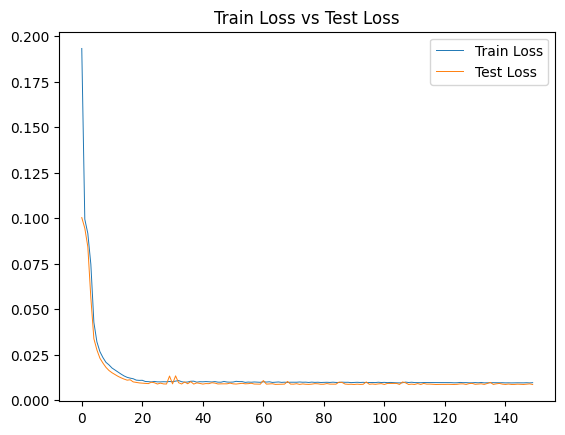

In [18]:
plt.plot(train_loss_rec, linewidth=0.7, label='Train Loss')
plt.plot(test_loss_rec, linewidth=0.7, label='Test Loss')
plt.legend()
plt.title('Train Loss vs Test Loss')
plt.show()

### Reload model

In [19]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
model.load_state_dict(torch.load('best_model/withoutsentiment.pth'))

C:\Users\mcgpr\AppData\Local\Temp/ipykernel_18040/689271088.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model/withoutsentiment

<All keys matched successfully>

### Test Set

In [20]:
predictions, targets, loss = evaluate_model(model, test_loader, criterion, test_scalers)
print(f'Loss on test set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Test Set: {r2:.4f}")

Loss on test set: 0.00859487
R² Coefficient on Test Set: 0.9989


### Validation Set

In [21]:
val_data_scaled, val_scalers = scale_sequences(val_sequence)

val_data = val_data_scaled
val_dataset = TimeSeriesDataset(val_data_scaled)
generator = torch.Generator()
generator.manual_seed(42)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, generator=generator)

predictions, targets, loss = evaluate_model(model, val_loader, criterion, val_scalers)
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Validation Set: {r2:.6f}")

R² Coefficient on Validation Set: 0.999028


Text(0, 0.5, 'Feature Value (High Price)')

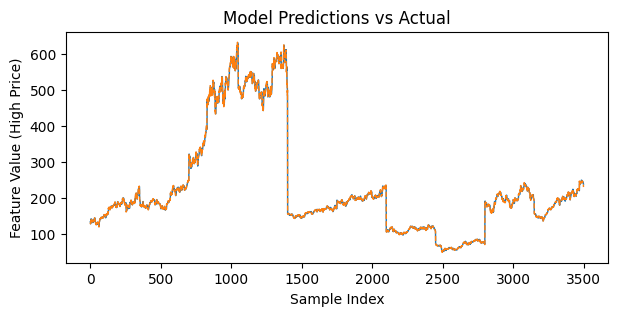

In [22]:
plt.figure(figsize=(7, 3))
plt.plot(predictions, label="Predicted", linestyle="-", linewidth=1)
plt.plot(targets, label="Actual", linestyle="--", linewidth=1)
plt.title("Model Predictions vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value (High Price)")

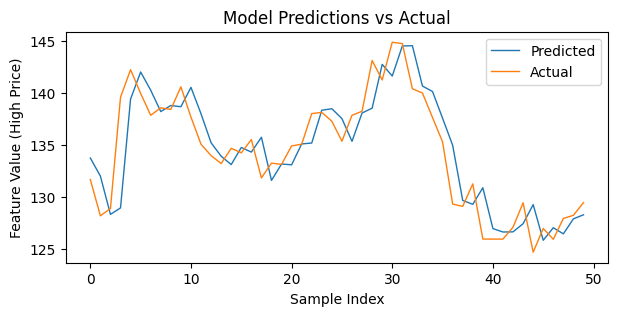

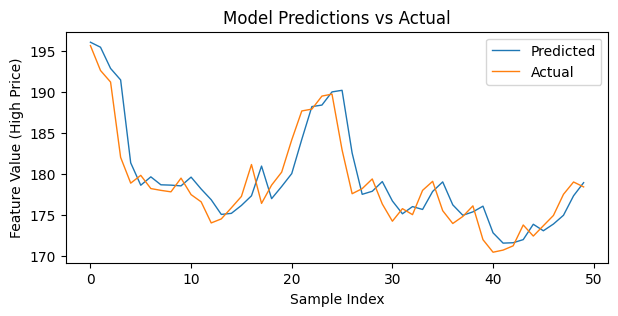

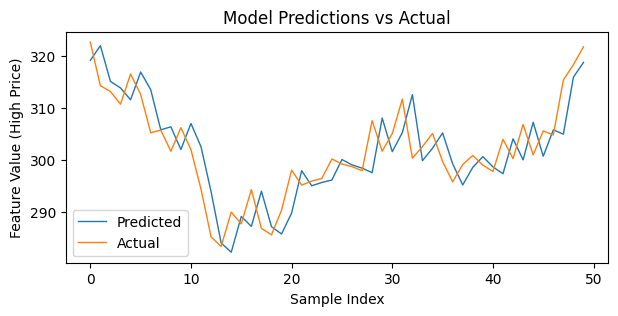

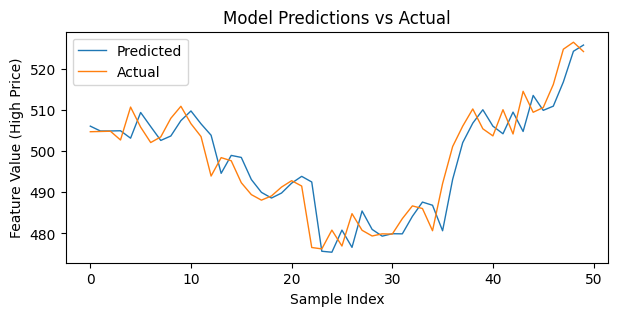

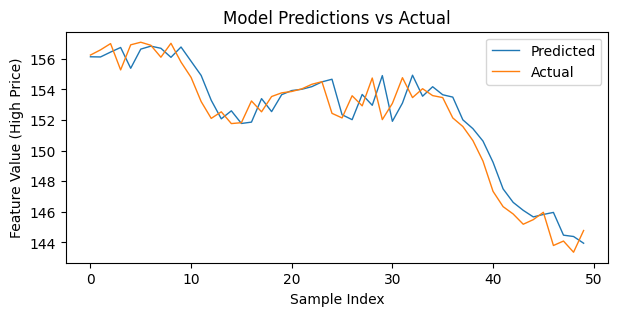

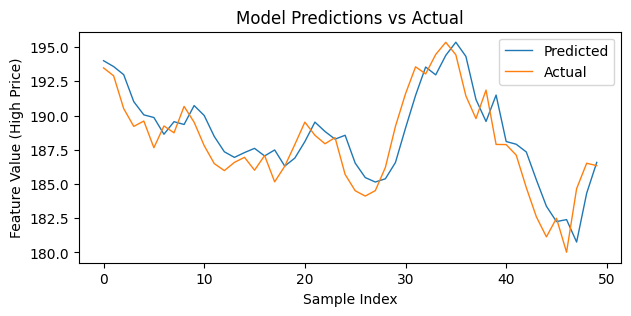

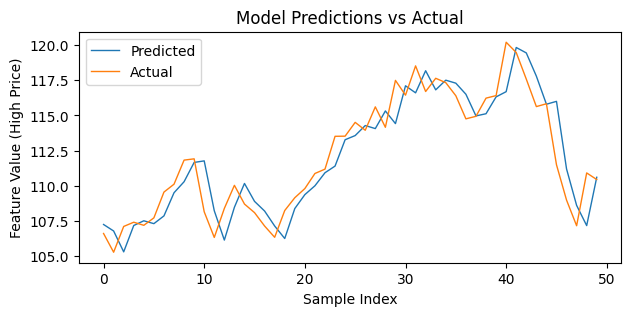

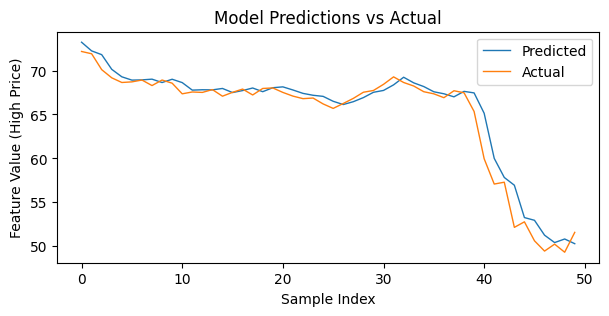

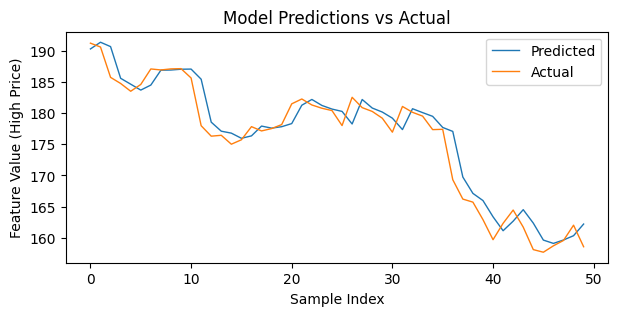

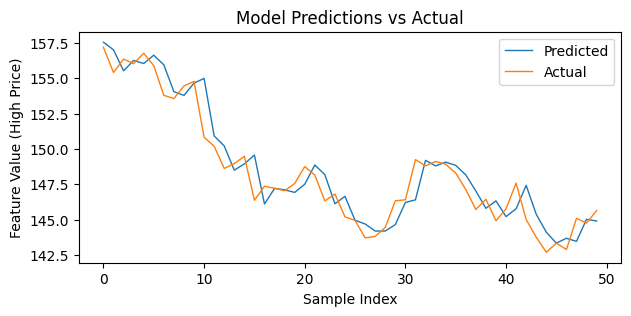

In [23]:
window = 50
for k in range(len(companies)):
    initial = 350*k
    plt.figure(figsize=(7, 3))
    plt.plot(predictions[initial: initial+window], label="Predicted", linestyle="-", linewidth=1)
    plt.plot(targets[initial: initial+window], label="Actual", linestyle="-", linewidth=1)
    plt.title("Model Predictions vs Actual")
    plt.xlabel("Sample Index")
    plt.ylabel("Feature Value (High Price)")
    plt.legend()
plt.show()

# Training the LSTM based model using price data and FinBERT sentiment analysis.

## Preprocessing

### Processing Data

In [39]:
prices, news = load_data(include_news=True)

In [40]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Move the model to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Get class labels
class_labels = model.config.id2label
prob_labels = model.config.label2id

# Example input text
text1 = news['content'].values[0]

inputs = tokenizer(text1, return_tensors="pt", truncation=True, padding=True)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Perform inference
with torch.no_grad():  # No gradient calculation needed for predictions
    outputs = model(**inputs)

# Compute probabilities and predicted class
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
predicted_class = torch.argmax(probs, dim=-1).item()

# Print the results
print("Predicted class:", class_labels[predicted_class])
print("Probabilities:", probs.cpu())  # Move probabilities back to CPU for printing
print('Labels assignation:', prob_labels)

Predicted class: neutral
Probabilities: tensor([[0.1068, 0.2003, 0.6929]])
Labels assignation: {'positive': 0, 'negative': 1, 'neutral': 2}


In [41]:
def sentiment_labelling(df):
    """
    Perform sentiment labelling on the given DataFrame.
    Adds 'negative', 'neutral', and 'positive' columns to the DataFrame.
    Processes the DataFrame to group by date and fill missing values.
    """
    model.to(device)

    df['negative'] = 0.0
    df['neutral'] = 0.0
    df['positive'] = 0.0

    # Initialize the tqdm progress bar
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Sentiment Analysis", dynamic_ncols=True):
        text = row['content']
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to CUDA
        with torch.no_grad():
            outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze().tolist()
        df.at[index, 'positive'] = probs[0]
        df.at[index, 'negative'] = probs[1]
        df.at[index, 'neutral'] = probs[2]

    # Drop unnecessary columns
    if {'url', 'title', 'content'}.issubset(df.columns):
        df = df.drop(columns=['url', 'title', 'content'])

    # Group by date and calculate mean sentiment scores
    df = df.groupby("date").mean().reset_index()

    # Ensure the 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Create a full date range
    date_range = pd.date_range(start=df["date"].min(), end=df["date"].max())

    # Reindex to include all dates and forward-fill missing values
    df = df.set_index("date").reindex(date_range)
    df = df.fillna(method="ffill").reset_index()
    df.rename(columns={"index": "date"}, inplace=True)

    df = df.sort_values(by="date", ascending=True).reset_index(drop=True)

    return df

In [42]:
news = sentiment_labelling(news)

Processing Sentiment Analysis: 100%|██████████| 6886/6886 [02:46<00:00, 41.26it/s]


In [43]:
news.head()

,date,negative,neutral,positive
0,2017-01-24,0.200346,0.692896,0.106758
1,2017-01-25,0.027849,0.678937,0.293214
2,2017-01-26,0.057628,0.740360,0.202012
3,2017-01-27,0.685202,0.247965,0.066833
4,2017-01-28,0.685202,0.247965,0.066833


In [44]:
merged = pd.merge(prices, news, on='date', how='inner')
train, val, split_date = date_train_val_split(merged, train_size=0.8)

In [45]:
train.head()

,Open,High,Low,Close,Volume,Company,date,negative,neutral,positive
0,13.960000,14.340000,13.950000,14.240000,16160200,Regions Financial Corporation,2017-01-24,0.200346,0.692896,0.106758
1,1678.000000,1719.479980,1678.000000,1700.000000,45200,"NVR, Inc.",2017-01-24,0.200346,0.692896,0.106758
2,39.623909,40.496979,39.469444,40.449966,1372858,Pentair,2017-01-24,0.200346,0.692896,0.106758
3,84.970001,86.580002,84.959999,86.400002,737800,Wabtec,2017-01-24,0.200346,0.692896,0.106758
4,167.160004,169.750000,167.160004,169.509995,600800,Domino's,2017-01-24,0.200346,0.692896,0.106758


In [46]:
merged.head()

,Open,High,Low,Close,Volume,Company,date,negative,neutral,positive
0,13.960000,14.340000,13.950000,14.240000,16160200,Regions Financial Corporation,2017-01-24,0.200346,0.692896,0.106758
1,1678.000000,1719.479980,1678.000000,1700.000000,45200,"NVR, Inc.",2017-01-24,0.200346,0.692896,0.106758
2,39.623909,40.496979,39.469444,40.449966,1372858,Pentair,2017-01-24,0.200346,0.692896,0.106758
3,84.970001,86.580002,84.959999,86.400002,737800,Wabtec,2017-01-24,0.200346,0.692896,0.106758
4,167.160004,169.750000,167.160004,169.509995,600800,Domino's,2017-01-24,0.200346,0.692896,0.106758


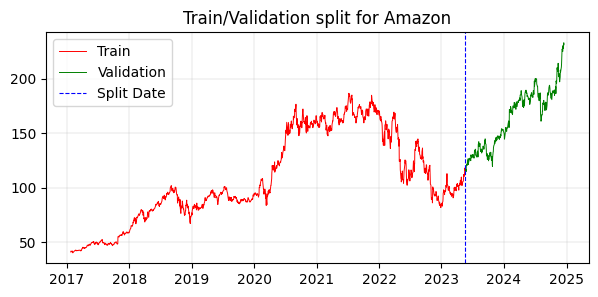

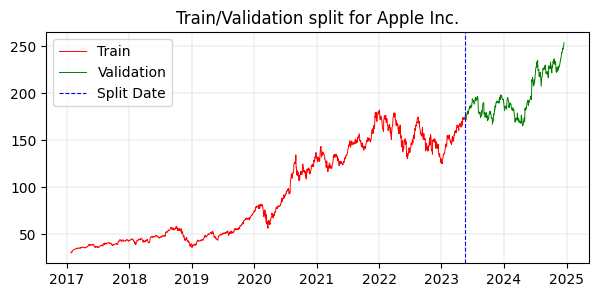

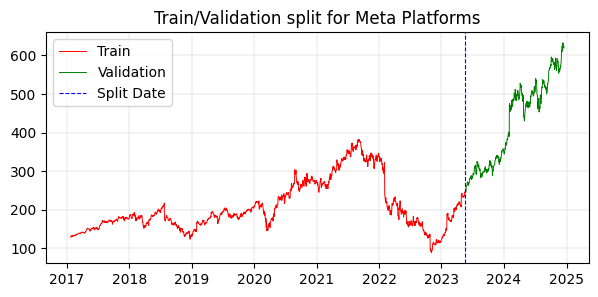

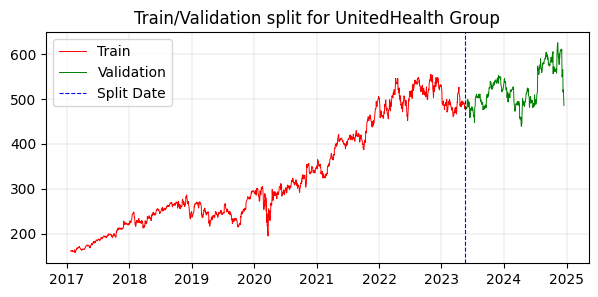

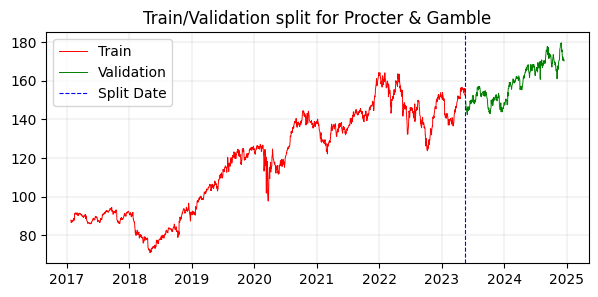

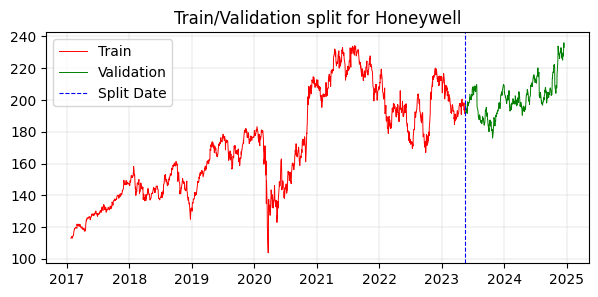

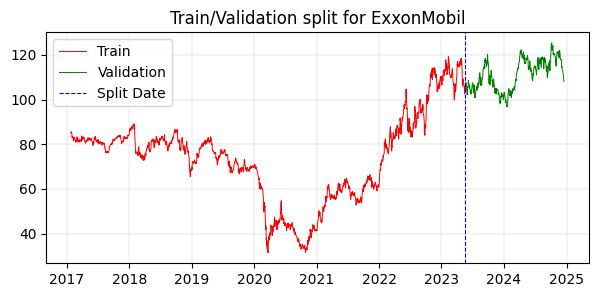

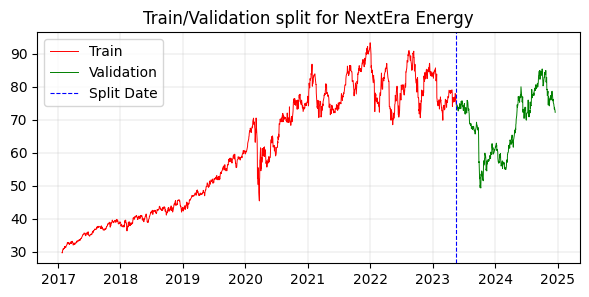

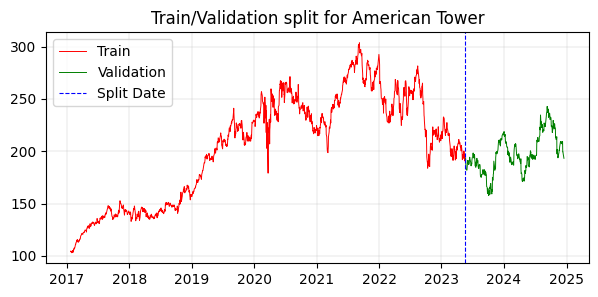

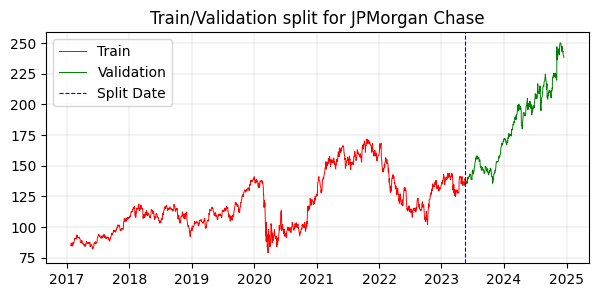

In [47]:
for company in companies:
    train_ex = train[train['Company'] == company]['Close'].values
    train_dates = train['date'].drop_duplicates().values
    val_ex = val[val['Company'] == company]['Close'].values
    val_dates = val['date'].drop_duplicates().values

    plt.figure(figsize=(7, 3))
    plt.grid(linewidth=0.2)
    plt.plot(train_dates, train_ex, linewidth=0.7, label='Train', c='r')
    plt.plot(val_dates, val_ex, linewidth=0.7, label='Validation', c='g')
    plt.axvline(x=split_date, color='b', linestyle='--', linewidth=0.8, label='Split Date')
    plt.legend()
    plt.title(f'Train/Validation split for {company}')
plt.show()

### Data Augmentation

In [48]:
train_sequence = sequencing(train, companies, 70, include_news=True)
val_sequence = sequencing(val, companies, 50, include_news=True)

print(f'sequenced train data: {train_sequence.shape}')
print(f'sequenced validation data: {val_sequence.shape}')

sequenced train data: (15220, 70, 4)
sequenced validation data: (3470, 50, 4)


### Scaling

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(train_sequence, test_size=0.2, random_state=42, shuffle=True)
train_data = np.array(train_data)
test_data = np.array(test_data)

# Scale training and testing data
train_data_scaled, train_scalers = scale_sequences(train_data)
test_data_scaled, test_scalers = scale_sequences(test_data)

# Update datasets with scaled data
train_data = train_data_scaled
test_data = test_data_scaled

# Prepare PyTorch datasets and data loaders
train_dataset = TimeSeriesDataset(train_data)
test_dataset = TimeSeriesDataset(test_data)

generator = torch.Generator()
generator.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, generator=generator)

## Training

In [55]:
input_dim = train_data.shape[2]
hidden_dim = 64
num_layers = 1
output_dim = 1

learning_rate=  0.001
dropout = 0.1
weight_decay = 5e-5

num_epochs = 256

model = LSTM(
    input_dim, 
    hidden_dim, 
    num_layers, 
    output_dim
).to(device)

early_stopping = EarlyStopping(
    patience=32,
    save_path='best_model/FinBert.pth'
)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay
)
steps_per_epoch = len(train_loader)  # Total number of batches in one epoch

scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch
)

train_loss_rec = []
test_loss_rec = []

print('Model defined, start training ...')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
    
    # Testing loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            test_outputs = model(x_test)
            loss = criterion(test_outputs.squeeze(), y_test)
            test_loss += loss.item()
    
    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.8f}, "
          f"Test Loss: {test_loss/len(test_loader):.8f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    train_loss_rec.append(train_loss/len(train_loader))
    test_loss_rec.append(test_loss/len(test_loader))
    
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

Model defined, start training ...
Epoch [1/256], Train Loss: 0.11188405, Test Loss: 0.09098080, LR: 0.000040
Validation loss improved. Model saved to best_model/FinBert.pth
Epoch [2/256], Train Loss: 0.07989136, Test Loss: 0.05764565, LR: 0.000042
Validation loss improved. Model saved to best_model/FinBert.pth
Epoch [3/256], Train Loss: 0.03932260, Test Loss: 0.02940703, LR: 0.000044
Validation loss improved. Model saved to best_model/FinBert.pth
Epoch [4/256], Train Loss: 0.02736337, Test Loss: 0.02300526, LR: 0.000046
Validation loss improved. Model saved to best_model/FinBert.pth
Epoch [5/256], Train Loss: 0.02235070, Test Loss: 0.01968607, LR: 0.000050
Validation loss improved. Model saved to best_model/FinBert.pth
Epoch [6/256], Train Loss: 0.01975852, Test Loss: 0.01785669, LR: 0.000054
Validation loss improved. Model saved to best_model/FinBert.pth
Epoch [7/256], Train Loss: 0.01802970, Test Loss: 0.01624309, LR: 0.000060
Validation loss improved. Model saved to best_model/FinBe

## Result

### Train/Test loss through epochs

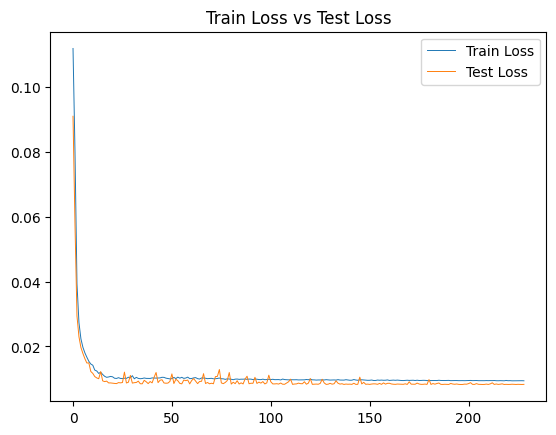

In [56]:
plt.plot(train_loss_rec, linewidth=0.7, label='Train Loss')
plt.plot(test_loss_rec, linewidth=0.7, label='Test Loss')
plt.legend()
plt.title('Train Loss vs Test Loss')
plt.show()

### Reload Model

In [57]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
model.load_state_dict(torch.load('best_model/FinBert.pth'))

C:\Users\mcgpr\AppData\Local\Temp/ipykernel_13744/2839631630.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model/FinBert.pth'))


<All keys matched successfully>

### Test Set

In [58]:
predictions, targets, loss = evaluate_model(model, test_loader, criterion, test_scalers)
print(f'Loss on test set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Test Set: {r2:.4f}")

Loss on test set: 0.00828888
R² Coefficient on Test Set: 0.9991


### Validation Set

In [59]:
val_data_scaled, val_scalers = scale_sequences(val_sequence)

val_data = val_data_scaled
val_dataset = TimeSeriesDataset(val_data_scaled)
generator = torch.Generator()
generator.manual_seed(42)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, generator=generator)

predictions, targets, loss = evaluate_model(model, val_loader, criterion, val_scalers)
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Validation Set: {r2:.6f}")

R² Coefficient on Validation Set: 0.999034


Text(0, 0.5, 'Feature Value (High Price)')

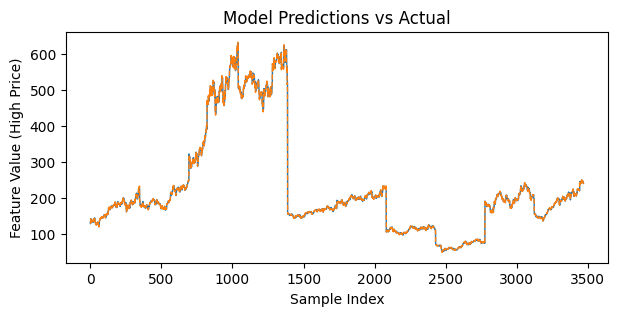

In [60]:
plt.figure(figsize=(7, 3))
plt.plot(predictions, label="Predicted", linestyle="-", linewidth=1)
plt.plot(targets, label="Actual", linestyle="--", linewidth=1)
plt.title("Model Predictions vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value (High Price)")

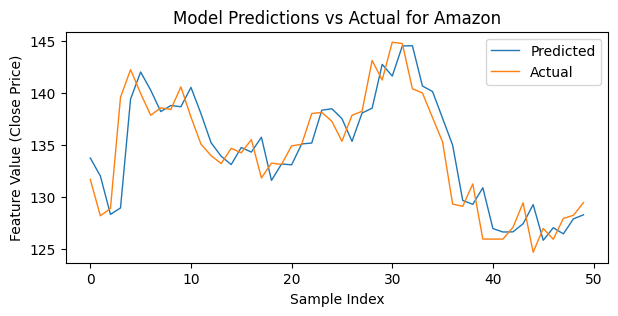

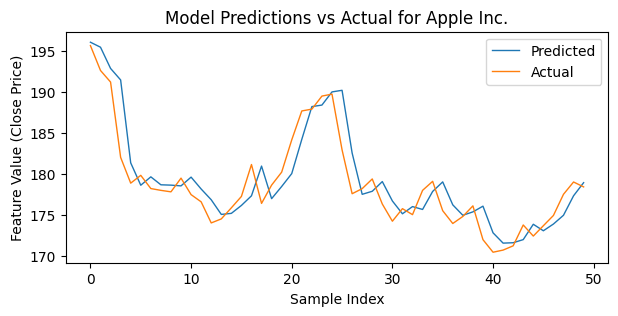

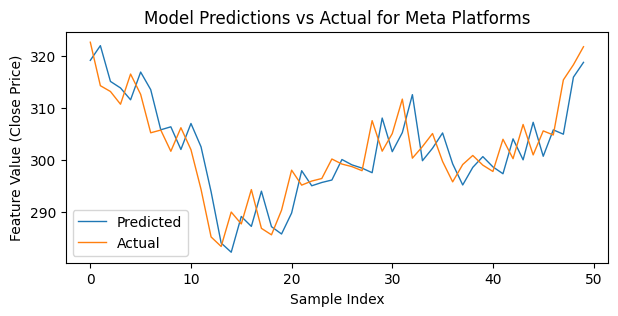

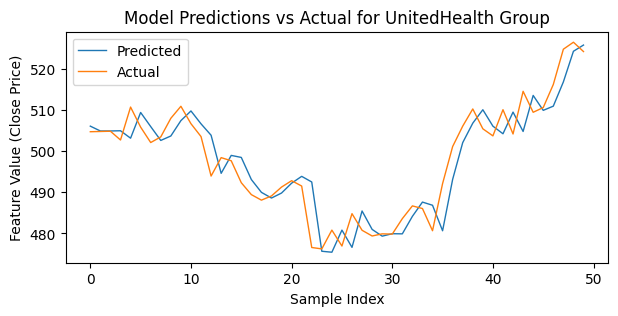

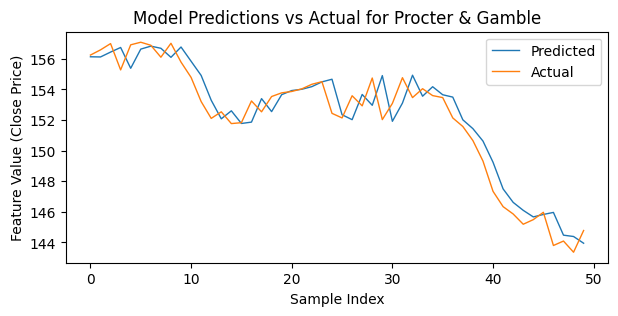

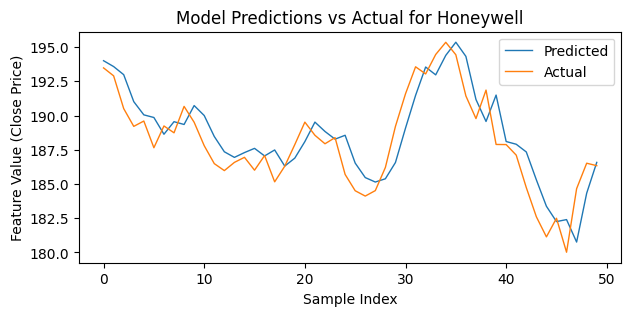

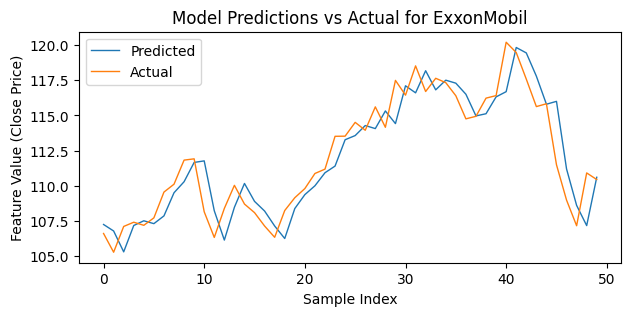

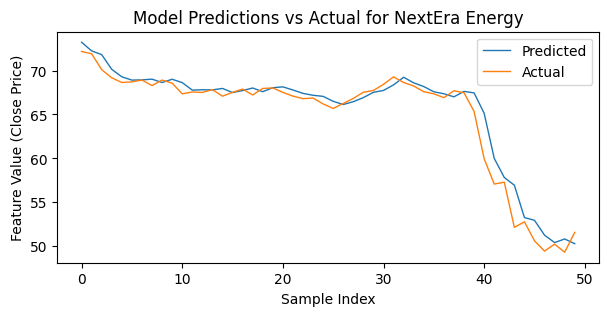

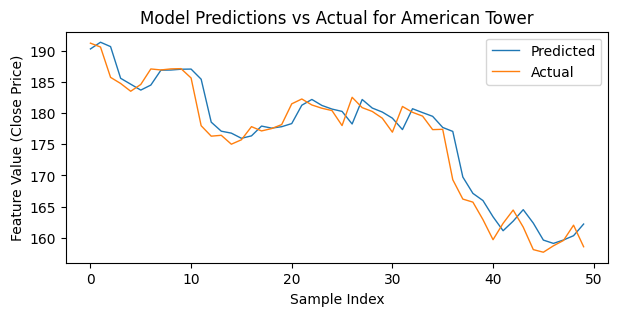

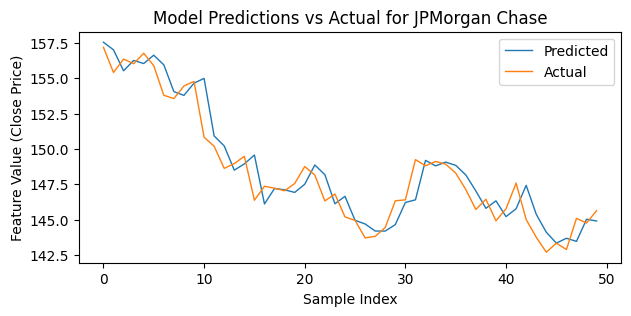

In [24]:
window = 50
for k in range(len(companies)):
    initial = 350*k
    plt.figure(figsize=(7, 3))
    plt.plot(predictions[initial: initial+window], label="Predicted", linestyle="-", linewidth=1)
    plt.plot(targets[initial: initial+window], label="Actual", linestyle="-", linewidth=1)
    plt.title(f"Model Predictions vs Actual for {companies[k]}")
    plt.xlabel("Sample Index")
    plt.ylabel("Feature Value (Close Price)")
    plt.legend()
plt.show()

# Training the LSTM based model using price data and Loughran Mcdonald sentiment dictionary.

## Preprocessing

### Data Processing

In [40]:
prices, news = load_data(include_news=True)

In [41]:
from datasets import load_loughran_mcdonald_dictionary

In [42]:
lm = load_loughran_mcdonald_dictionary()

INFO:datasets:Loading from cache file: data\Loughran-McDonald_MasterDictionary_1993-2023.csv


In [43]:
def sentiment_labelling(df, lm, column):
    """
    Perform sentiment labelling on the given DataFrame.
    Adds 'negative', 'neutral', and 'positive' columns to the DataFrame.
    Processes the DataFrame to group by date and fill missing values.
    """
    # Initialize sentiment columns
    # Extract the text column
    X = df[column]
    
    # Define sentiment functions
    funcs = {
        "negative": lambda x: x.Negative > 0,
        "positive": lambda x: x.Positive > 0,
        "all": lambda x: x.Word.notna(),
    }

    # Helper function to compute total count for a specific sentiment
    def get_total_count(X, lm, func):
        m = CountVectorizer(vocabulary=lm.loc[func].Word.str.lower().values)
        return pd.DataFrame(m.fit_transform(X).toarray(), index=X.index).sum(axis=1)

    # Compute sentiment counts for each sentiment category
    lm_counts = pd.concat({k: get_total_count(X, lm, v) for k, v in funcs.items()}, axis=1)

    sentiment_columns = ["negative", "positive"]
    lm_counts[sentiment_columns] = lm_counts[sentiment_columns].div(lm_counts[sentiment_columns].sum(axis=1), axis=0)

    lm_counts.drop(columns=["all"], inplace=True)

    if 'date' in df.columns:
        lm_counts['date'] = df['date'].values

    lm_counts.reset_index(drop=True, inplace=True)

    if {'url', 'title', 'content'}.issubset(df.columns):
        df = df.drop(columns=['url', 'title', 'content'])

    lm_counts = lm_counts.groupby("date").mean().reset_index()

    lm_counts['date'] = pd.to_datetime(lm_counts['date'])

    date_range = pd.date_range(start=lm_counts["date"].min(), end=lm_counts["date"].max())

    lm_counts = lm_counts.set_index("date").reindex(date_range)
    lm_counts = lm_counts.fillna(method="ffill").reset_index()
    lm_counts.rename(columns={"index": "date"}, inplace=True)

    lm_counts = lm_counts.sort_values(by="date", ascending=True).reset_index(drop=True)

    return lm_counts

In [44]:
news = sentiment_labelling(news, lm, 'content')

In [45]:
news.head()

,date,negative,positive
0,2017-01-24,0.563636,0.436364
1,2017-01-25,0.448746,0.551254
2,2017-01-26,0.482812,0.517188
3,2017-01-27,0.730769,0.269231
4,2017-01-28,0.730769,0.269231


In [46]:
merged = pd.merge(prices, news, on='date', how='inner')
train, val, split_date = date_train_val_split(merged, train_size=0.8)

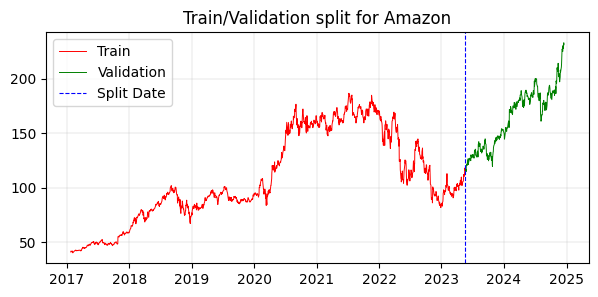

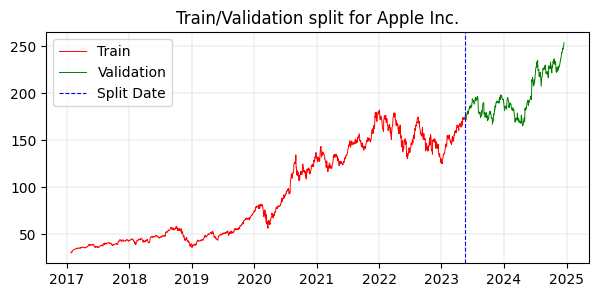

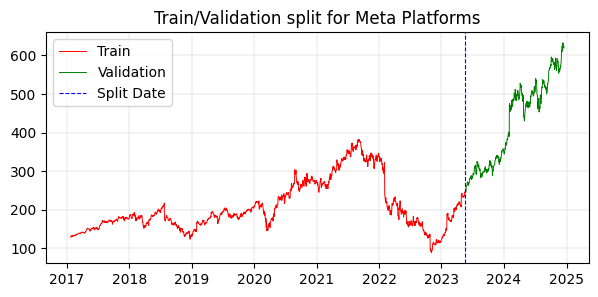

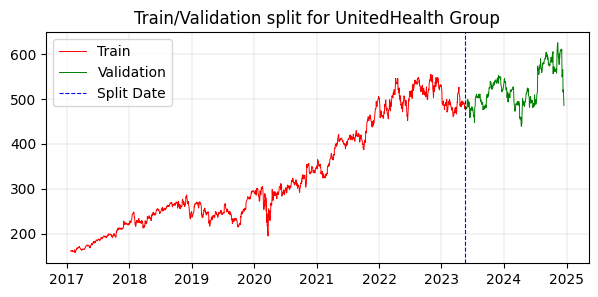

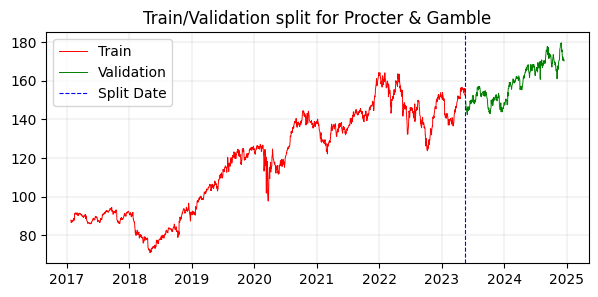

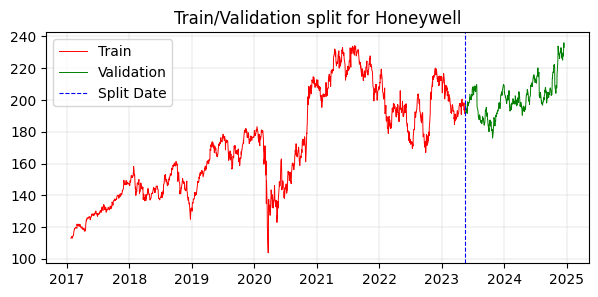

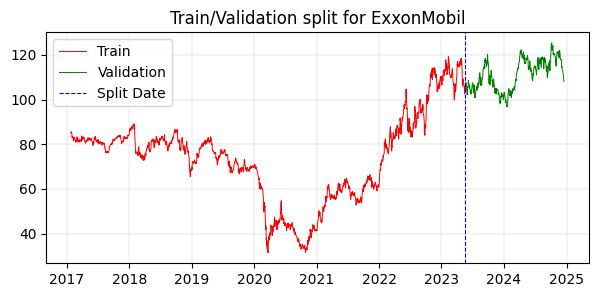

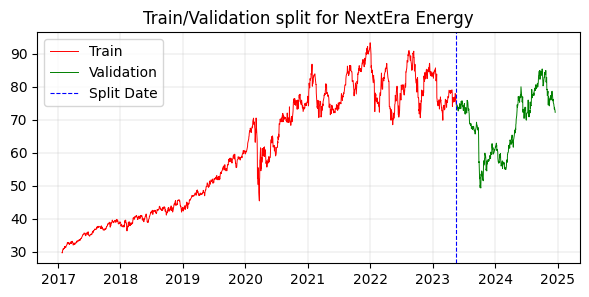

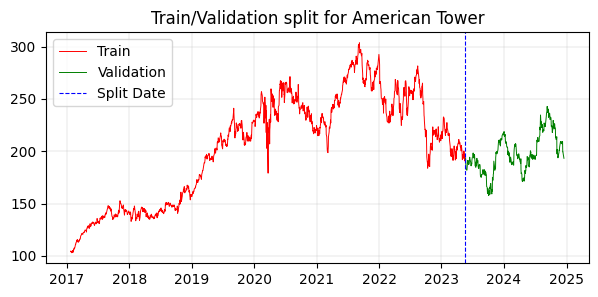

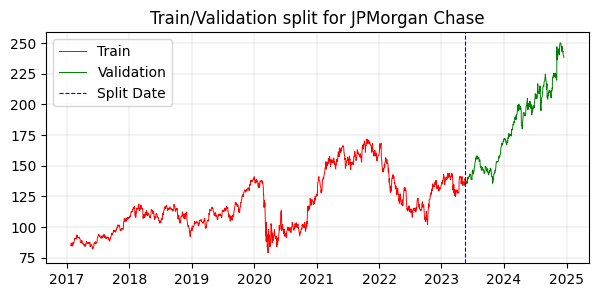

In [47]:
for company in companies:
    train_ex = train[train['Company'] == company]['Close'].values
    train_dates = train['date'].drop_duplicates().values
    val_ex = val[val['Company'] == company]['Close'].values
    val_dates = val['date'].drop_duplicates().values

    plt.figure(figsize=(7, 3))
    plt.grid(linewidth=0.2)
    plt.plot(train_dates, train_ex, linewidth=0.7, label='Train', c='r')
    plt.plot(val_dates, val_ex, linewidth=0.7, label='Validation', c='g')
    plt.axvline(x=split_date, color='b', linestyle='--', linewidth=0.8, label='Split Date')
    plt.legend()
    plt.title(f'Train/Validation split for {company}')
plt.show()

In [ ]:
merged.head()

,Open,High,Low,Close,Volume,Company,date,negative,positive
0,13.960000,14.340000,13.950000,14.240000,16160200,Regions Financial Corporation,2017-01-24,0.563636,0.436364
1,1678.000000,1719.479980,1678.000000,1700.000000,45200,"NVR, Inc.",2017-01-24,0.563636,0.436364
2,39.623909,40.496979,39.469444,40.449966,1372858,Pentair,2017-01-24,0.563636,0.436364
3,84.970001,86.580002,84.959999,86.400002,737800,Wabtec,2017-01-24,0.563636,0.436364
4,167.160004,169.750000,167.160004,169.509995,600800,Domino's,2017-01-24,0.563636,0.436364


### Data Augmentation

In [49]:
train_sequence = sequencing(train, companies, 70, include_news=True)
val_sequence = sequencing(val, companies, 50, include_news=True)

print(f'sequenced train data: {train_sequence.shape}')
print(f'sequenced validation data: {val_sequence.shape}')

sequenced train data: (15220, 70, 3)
sequenced validation data: (3470, 50, 3)


### Scaling 

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(train_sequence, test_size=0.2, random_state=42, shuffle=True)
train_data = np.array(train_data)
test_data = np.array(test_data)

# Scale training and testing data
train_data_scaled, train_scalers = scale_sequences(train_data)
test_data_scaled, test_scalers = scale_sequences(test_data)

# Update datasets with scaled data
train_data = train_data_scaled
test_data = test_data_scaled

# Prepare PyTorch datasets and data loaders
train_dataset = TimeSeriesDataset(train_data_scaled)
test_dataset = TimeSeriesDataset(test_data_scaled)

generator = torch.Generator()
generator.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, generator=generator)

## Training

In [51]:
input_dim = train_data.shape[2]
hidden_dim = 64
num_layers = 1
output_dim = 1

learning_rate=  0.0005
dropout = 0.1
weight_decay = 5e-5

num_epochs = 256

model = LSTM(
    input_dim, 
    hidden_dim, 
    num_layers, 
    output_dim
).to(device)

early_stopping = EarlyStopping(
    patience=32,
    save_path='best_model/lough_macdo.pth'
)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay
)
steps_per_epoch = len(train_loader)  # Total number of batches in one epoch

scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch
)

train_loss_rec = []
test_loss_rec = []

print('Model defined, start training ...')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            test_outputs = model(x_test)
            loss = criterion(test_outputs.squeeze(), y_test)
            test_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.8f}, "
          f"Test Loss: {test_loss/len(test_loader):.8f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    train_loss_rec.append(train_loss/len(train_loader))
    test_loss_rec.append(test_loss/len(test_loader))
    
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

Model defined, start training ...
Epoch [1/256], Train Loss: 0.14778406, Test Loss: 0.10108000, LR: 0.000020
Validation loss improved. Model saved to best_model/lough_macdo.pth
Epoch [2/256], Train Loss: 0.09919047, Test Loss: 0.09334570, LR: 0.000021
Validation loss improved. Model saved to best_model/lough_macdo.pth
Epoch [3/256], Train Loss: 0.08697237, Test Loss: 0.07246291, LR: 0.000022
Validation loss improved. Model saved to best_model/lough_macdo.pth
Epoch [4/256], Train Loss: 0.05407683, Test Loss: 0.04070769, LR: 0.000023
Validation loss improved. Model saved to best_model/lough_macdo.pth
Epoch [5/256], Train Loss: 0.03678905, Test Loss: 0.03513713, LR: 0.000025
Validation loss improved. Model saved to best_model/lough_macdo.pth
Epoch [6/256], Train Loss: 0.02888903, Test Loss: 0.02598918, LR: 0.000027
Validation loss improved. Model saved to best_model/lough_macdo.pth
Epoch [7/256], Train Loss: 0.02663166, Test Loss: 0.02617199, LR: 0.000030
EarlyStopping counter: 1 out of 3

## Result

### Train/Test Loss through epochs

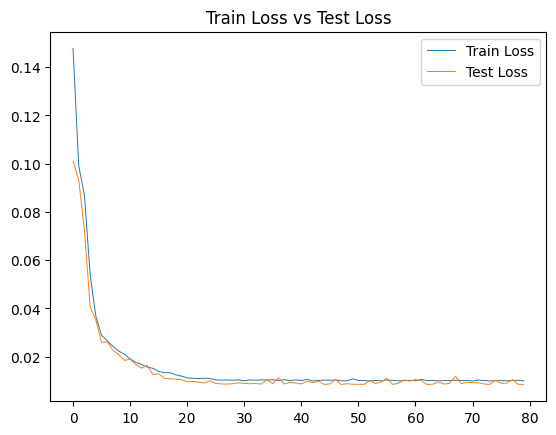

In [52]:
plt.plot(train_loss_rec, linewidth=0.7, label='Train Loss')
plt.plot(test_loss_rec, linewidth=0.7, label='Test Loss')
plt.legend()
plt.title('Train Loss vs Test Loss')
plt.show()

### Reload

In [53]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
model.load_state_dict(torch.load('best_model/lough_macdo.pth'))

C:\Users\mcgpr\AppData\Local\Temp/ipykernel_8136/2950336300.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model/lough_macdo.pth'

<All keys matched successfully>

### Test Set

In [ ]:
predictions, targets, loss = evaluate_model(model, test_loader, criterion, test_scalers)
print(f'Loss on test set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Test Set: {r2:.4f}")

Loss on test set: 0.00848438
R² Coefficient on Test Set: 0.9990


### Validation Set

In [ ]:
val_data_scaled, val_scalers = scale_sequences(val_sequence)

val_data = val_data_scaled
val_dataset = TimeSeriesDataset(val_data_scaled)
generator = torch.Generator()
generator.manual_seed(42)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, generator=generator)

predictions, targets, loss = evaluate_model(model, val_loader, criterion, val_scalers)
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Validation Set: {r2:.6f}")

R² Coefficient on Validation Set: 0.999012


Text(0, 0.5, 'Feature Value (Close Price)')

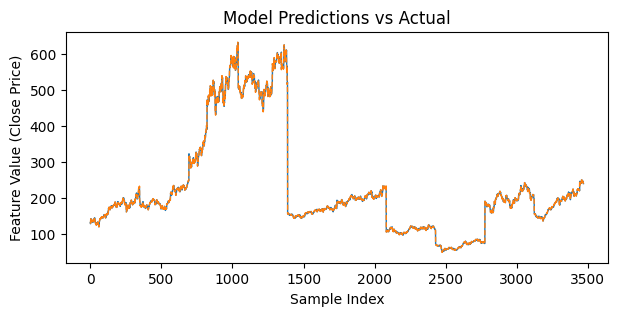

In [ ]:
plt.figure(figsize=(7, 3))
plt.plot(predictions, label="Predicted", linestyle="-", linewidth=1)
plt.plot(targets, label="Actual", linestyle="--", linewidth=1)
plt.title("Model Predictions vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value (Close Price)")

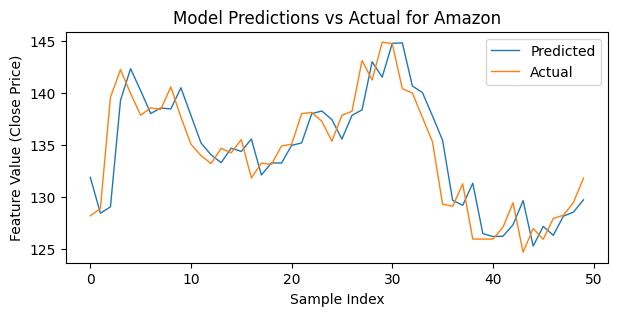

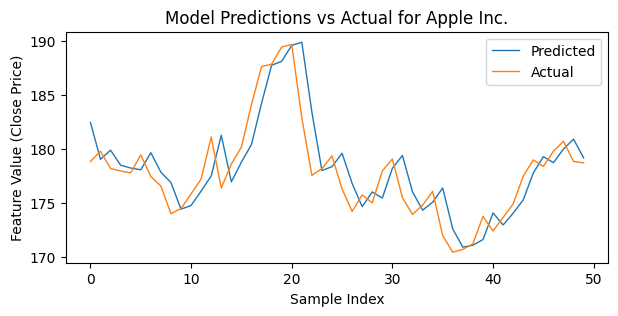

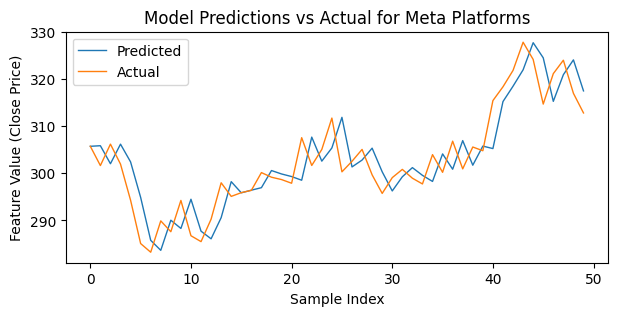

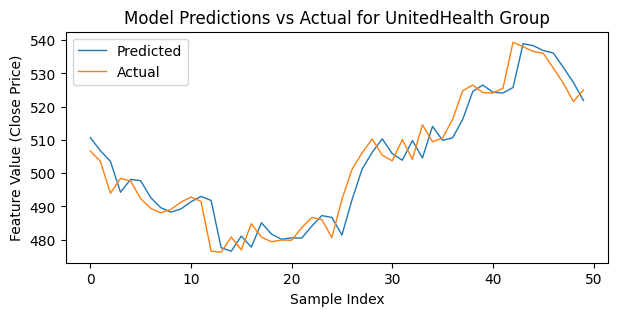

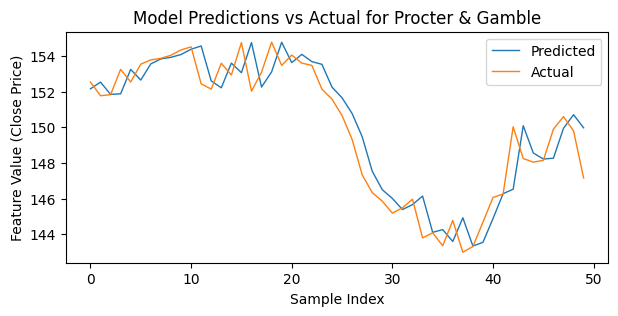

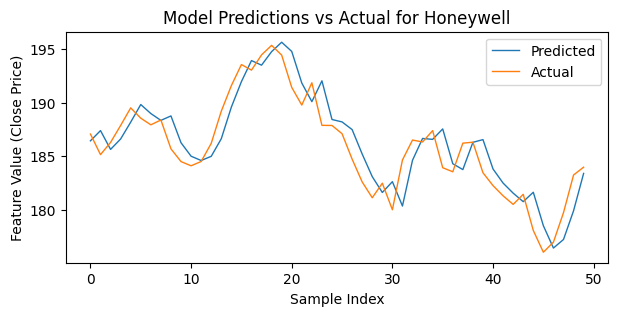

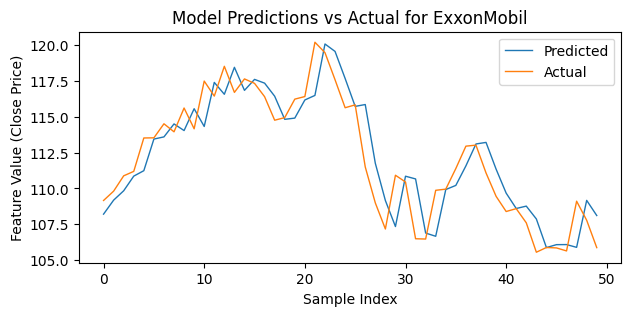

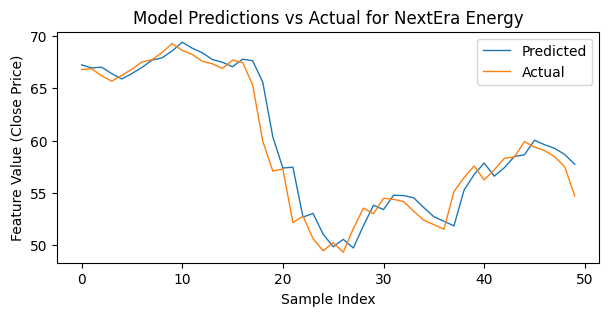

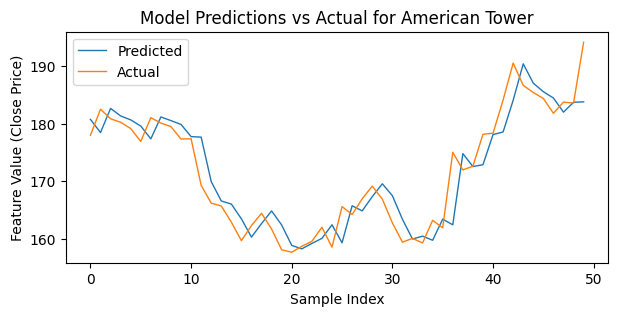

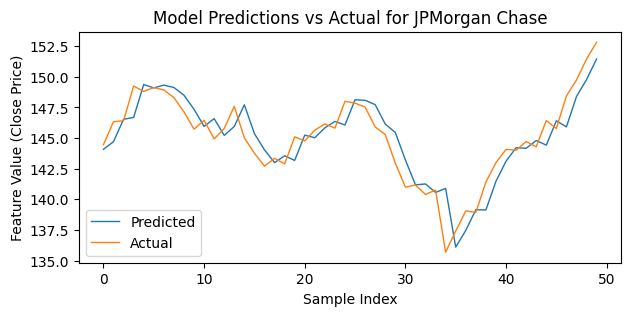

In [57]:
window = 50
for k in range(len(companies)):
    initial = 350*k
    plt.figure(figsize=(7, 3))
    plt.plot(predictions[initial: initial+window], label="Predicted", linestyle="-", linewidth=1)
    plt.plot(targets[initial: initial+window], label="Actual", linestyle="-", linewidth=1)
    plt.title(f"Model Predictions vs Actual for {companies[k]}")
    plt.xlabel("Sample Index")
    plt.ylabel("Feature Value (Close Price)")
    plt.legend()
plt.show()

# Conclusion

To conclude, the result showed that we got better result using sentiment analysis. But do all those efforts were that worht ? That's